## Manage Packages

In [1]:
# Import all required packages
import pandas as pd                   # For data manipulation and analysis
import gurobipy as grb                # Gurobi optimization library for solving mathematical models
import io
import gymnasium as gym

from gymnasium import spaces
import numpy as np
import os
import pickle
import copy
import random
import time
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import matplotlib.ticker as ticker
import warnings
from concurrent.futures import ProcessPoolExecutor
import multiprocessing

import numpy as np
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from scipy.stats import ttest_ind
import seaborn as sns

from stable_baselines3 import PPO
from stable_baselines3 import DQN
from stable_baselines3 import A2C
from sb3_contrib import MaskablePPO

from stable_baselines3.common.vec_env import SubprocVecEnv, DummyVecEnv, VecNormalize
from stable_baselines3.common.env_util import make_vec_env

from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import BaseCallback, CheckpointCallback, EvalCallback
from stable_baselines3.common.monitor import Monitor
from gymnasium.wrappers import FlattenObservation
from sb3_contrib.common.maskable.utils import get_action_masks

# Import custom zero counting function
def count_zeros(arr):
    return np.count_nonzero(arr < 0.00001)


# Import custom environment .py file
#import custom_env as ce #original
#import custom_env_F as ce #modified for curriculum learning
import env_IM as ce #modified for curriculum learning

2025-09-07 00:33:50.905235: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-07 00:33:50.918069: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-07 00:33:50.934534: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-07 00:33:50.939574: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-07 00:33:50.951110: I tensorflow/core/platform/cpu_feature_guar

## Input Graph and File Names and Load Trained Models

In [2]:
# Inputs
graphName = "G5x5"
#graphName = "G8x8"
graphName = "G3x4"

model_names = [#"G5x5_D_PPO_EX004LSTM",
                 "G3x4_S_DQN_EX001A",
                 "G3x4_S_DQN_EX001A1",
                 "G3x4_S_DQN_EX001B",

   #             "G5x5_S_DQN_EX001A",
   #             "G8x8_S_DQN_EX001A",
   #             "G8x8_S_DQN_EX001B",
   #             "G8x8_S_DQN_EX001C",
   #             "G8x8_S_DQN_EX001D",
    #       "G5x5_S_DQN_EX006A",
        #       "G5x5_S_A2C_EX006A",
        #        "G5x5_S_PPO_EX006A",
        #        "G5x5_S_PPO_EX006M1",
        #       "G5x5_S_DQN_EX006M",
        #       "G5x5_S_A2C_EX006M",
        #        "G5x5_S_MaskablePPO_EX005A",
        #        "G5x5_S_MaskablePPO_EX005C",
        #        "G8x8_S_PPO_EX006A",
        #       "G8x8_S_PPO_EX005LSTM",
        #        "G8x8_S_A2C_EX005",           
        #        "G8x8_S_DQN_EX005",
        #        "G8x8_S_DQN_EX005A",
        #        "G8x8_S_DQN_EX005C",
        #       "G8x8_S_DQN_EX005D",
              ]

model_timesteps = [15876000,
                   20916000,
                   4536000,
                   8064000,
                   49140000, # or {model_name}_{timestepsPPO}_steps
                   45108000,
                   42840000,
                   9576000
                  ]

# Environement Characteristics
env_deterministic = False
env_fixed_costs = False
env_curriculum_training = False
env_initial_budget = None
env_multiple_interdiction = False
env_max_budget = 5

# Get the current working directory
current_dir = os.getcwd()
models_dir = os.path.join(current_dir, '..', 'Trained_RL_Models')

# LOAD Previous saved model
model_paths = []
data = []

for i, name in enumerate(model_names):
    model_paths.append(f"{models_dir}/{name}/best_model")
#    model_paths.append(f"{models_dir}/{name}/{name}_{model_timesteps[i]}_steps")

    data.append(np.load(f"{models_dir}/{name}/evaluations.npz"))

# Graph nodes and edges to use
node_filename = f"{graphName}_Nodes.csv"  # Dynamically include graphName
edge_filename = f"{graphName}_Edges.csv"  # Dynamically include graphName

# Create nodes and edges
nodes, edges = ce.create_nodes_edges(node_filename, edge_filename)

# Load Environment
#env = FlattenObservation(CustomEnv(nodes, edges))
env = ce.CustomEnv(nodes, edges, deterministic_agent=env_deterministic,
                   fixed_costs= env_fixed_costs,
                   curriculum_training=env_curriculum_training,
                   initial_budget=env_initial_budget, 
                   min_training_budget=5,
                   max_training_budget=24,#env_max_budget, 
                   multiple_interdiction_attempts=env_multiple_interdiction)

eval_env = ce.CustomEnv(nodes, edges, deterministic_agent=env_deterministic,
                   fixed_costs= env_fixed_costs,
                   curriculum_training=env_curriculum_training,
                   initial_budget=env_initial_budget,
                   min_training_budget=5,
                   max_training_budget=24,#env_max_budget,                   
                   multiple_interdiction_attempts=env_multiple_interdiction)

env = DummyVecEnv([lambda: env])

# 2. Load normalization statistics and wrap environment
#env = VecNormalize.load(f"{models_dir}/{model_names[0]}/{model_names[0]}_vecnormalize_{model_timesteps[0]}_steps.pkl", env)

# 3. Set evaluation mode
#env.training = False
#env.norm_reward = False

# Load the model
agents = []
for m in model_paths:
    if "MaskablePPO" in m:
        agents.append(MaskablePPO.load(m, env=env))
    elif "PPO" in m:
        agents.append(PPO.load(m, env=env))
    elif "DQN" in m:
        agents.append(DQN.load(m, env=env))
    elif "A2C" in m:
        agents.append(A2C.load(m, env=env))


## Plot Mean Reward Over Training Episodes

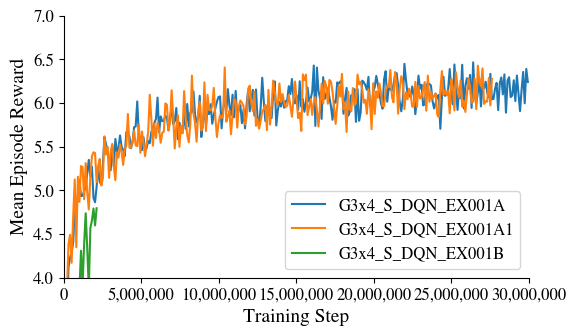

In [3]:
plt.figure(figsize=(6, 3.4))

plt.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

for i, d in enumerate(data):
    timesteps = d['timesteps']
    results = d['results']
    mean_rewards = np.mean(results, axis=1)
    plt.plot(timesteps, mean_rewards, label=model_names[i])

#plt.title('Deterministic Network Interdiction Agent Training')
plt.xlabel('Training Step')
plt.ylabel('Mean Episode Reward')
plt.legend()

#Adjust viewing window
plt.xlim(00000000, 30000000)
plt.ylim(4, 7)

# Set x-axis ticks at each million5
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(5000000))

# Format x-axis tick labels with commas
def format_func(value, tick_number):
    return f"{value:,.0f}"

plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_func))

sns.despine()
plt.savefig('AgentTraining_D.png', dpi=300, bbox_inches='tight', format='png')

plt.show()

## Test Agent Performance

In [4]:
# Modified Trial for VecNormalized

# Test Agent against a range of scenarios
num_of_scenarios = 100

# Initialize arrays to store results
max_flow_vals =  np.zeros(num_of_scenarios)
optimal_obj_vals = np.zeros(num_of_scenarios)
agent_best_rewards = np.zeros((num_of_scenarios, len(agents)))

# Initialize a dictionary to keep track of actions
action_tally = [{i: 0 for i in eval_env.interdictable_edges} for _ in agents]


all_optimal_interdiction_edges = []
all_agent_actions =[]
agent_solution_times = np.zeros((num_of_scenarios, len(agents)))
optimal_solution_times=[]

for episode in tqdm(range(num_of_scenarios)):
    env.seed(seed=episode)
    obs = env.reset()
    eval_env.reset(seed=episode)
    #Determine Original Flow
    max_flow_vals[episode] = eval_env.reference_obj

    #Solve and Time Optimal Solution
    start_optimal_time = time.perf_counter()
#    optimal_obj_val, optimal_interdiction_edges = eval_env.solve_optimal_interdiction()
    optimal_obj_val, optimal_interdiction_edges = eval_env.solve_stochastic_max_flow(n_scenarios = 1000)
    end_optimal_time = time.perf_counter()
    optimal_solution_times.append(end_optimal_time-start_optimal_time)

    #Save optimal solution value and interdiction set
    #print(optimal_obj_val)
    #print(optimal_interdiction_edges)
    optimal_obj_vals[episode] = optimal_obj_val
    all_optimal_interdiction_edges.append(frozenset(optimal_interdiction_edges))
    
    for a, agent in enumerate(agents):
        # Reset enviroments
        env.seed(seed=episode)
        obs = env.reset()
        #print(obs['budget'])
        eval_env.reset(seed=episode)
        action_list = []

        start_time = time.perf_counter()
        # Run agent with proper normalization
        for _ in range(31):
            # Get action mask through vectorized environment method
            #action_masks = env.env_method("action_masks")[0]
            action, _ = agent.predict(obs, deterministic=True)
            # Use wrapper's step method
            obs, reward, done, _ = env.step([action])  # Use vectorized step API
            eval_env.step(action)
            # Tally actions using inner environment
            if action != env.get_attr("num_interdictable_edges")[0]:
                if action.item()<270:
                    action_key = list(env.get_attr("interdictable_edges")[0])[action.item()]
                    action_tally[a][action_key] += 1
                    action_list.append(action_key)
            
            if done:
                break
        end_time = time.perf_counter()
        agent_solution_times[episode, a]=(end_time-start_time)
        all_agent_actions.append(frozenset(action_list))

        
        if env_deterministic ==True:
            # Get final objective value from inner environment
            objVal, _ = eval_env.solve_max_flow()
        else:
            interim_objective_value = np.empty(1000)
            for i in range(1000):
                interim_objective_value[i], _ = eval_env.solve_max_flow()
            objVal = np.mean(interim_objective_value)
            #print(objVal)

        agent_best_rewards[episode, a] = objVal

#Print Results
print("Optimal Time to Solve (Mean): ",np.mean(optimal_solution_times))
print("")

for a, agent in enumerate(agents):
    # Calculate relative errors
    relative_errors = abs(agent_best_rewards[:,a]-optimal_obj_vals) / (max_flow_vals-optimal_obj_vals)
    # Create boolean mask using set operations
    condition_mask = np.array([
        agent_actions.issuperset(optimal_edges)
        for agent_actions, optimal_edges in zip(all_agent_actions, all_optimal_interdiction_edges)
    ])

    # Apply mask to zero out qualifying elements
    relative_errors[condition_mask] = 0
    
    # Calculate mean relative error
    mean_relative_error = np.nanmean(relative_errors)
    print(model_names[a], ": ", count_zeros(relative_errors))
    print("Mean Relative Error: ", mean_relative_error)
    print("RL Time to Solve (Mean): ", np.mean(agent_solution_times[:, a]))
    print("")

100%|██████████| 100/100 [15:26<00:00,  9.27s/it]

Optimal Time to Solve (Mean):  4.65203946899157

G3x4_S_DQN_EX001A :  6
Mean Relative Error:  0.07528120568317638
RL Time to Solve (Mean):  1.2848556406470015

G3x4_S_DQN_EX001A1 :  7
Mean Relative Error:  0.059751237316659295
RL Time to Solve (Mean):  1.2096986438799648

G3x4_S_DQN_EX001B :  5
Mean Relative Error:  0.206095365230993
RL Time to Solve (Mean):  1.0285431034397334



In [26]:
a=3
num_of_scenarios = 1000


eval_env2 = ce.CustomEnv(nodes, edges, deterministic_agent=env_deterministic,
                   fixed_costs= env_fixed_costs,
                   curriculum_training=env_curriculum_training,
                   initial_budget=env_initial_budget,
                    min_training_budget = a,
                   max_training_budget=a,                   
                   multiple_interdiction_attempts=env_multiple_interdiction)

# Initialize arrays to store results
max_flow_vals2 =  np.zeros(num_of_scenarios)
optimal_obj_vals2 = np.zeros(num_of_scenarios)

for episode in tqdm(range(num_of_scenarios)):
    env.seed(seed=episode)
    eval_env2.reset(seed=episode)
    #Determine Original Flow
    max_flow_vals2[episode] = eval_env2.reference_obj

    optimal_obj_val, _ = eval_env2.solve_optimal_interdiction()
#    optimal_obj_val, optimal_interdiction_edges = eval_env.solve_stochastic_max_flow(n_scenarios = 1000)

    optimal_obj_vals2[episode] = optimal_obj_val
    result = max_flow_vals2-optimal_obj_vals2


100%|██████████| 1000/1000 [00:02<00:00, 350.98it/s]


In [27]:
import numpy as np
import pandas as pd
from tqdm import tqdm

num_of_scenarios = 1000
df = pd.DataFrame()

for a in range(3, 16):
    eval_env2 = ce.CustomEnv(
        nodes, edges,
        deterministic_agent=env_deterministic,
        fixed_costs=env_fixed_costs,
        curriculum_training=env_curriculum_training,
        initial_budget=env_initial_budget,
        min_training_budget=a,
        max_training_budget=a,
        multiple_interdiction_attempts=env_multiple_interdiction
    )
    max_flow_vals2 = np.zeros(num_of_scenarios)
    optimal_obj_vals2 = np.zeros(num_of_scenarios)
    for episode in tqdm(range(num_of_scenarios)):
        env.seed(seed=episode)
        eval_env2.reset(seed=episode)
        max_flow_vals2[episode] = eval_env2.reference_obj
        optimal_obj_val, _ = eval_env2.solve_optimal_interdiction()
        optimal_obj_vals2[episode] = optimal_obj_val
    result = max_flow_vals2 - optimal_obj_vals2
    df[f"a={a}"] = result

# Save results to Excel
df.to_csv("results.csv", index=False)


100%|██████████| 1000/1000 [00:01<00:00, 532.30it/s]


In [16]:
all_optimal_interdiction_edges

[frozenset({(2, 7)}),
 frozenset({(17, 22)}),
 frozenset({(11, 16)}),
 frozenset({(3, 8)}),
 frozenset({(8, 13)}),
 frozenset({(12, 17)}),
 frozenset({(21, 26)}),
 frozenset({(16, 21)}),
 frozenset({(11, 16)}),
 frozenset({(12, 17)}),
 frozenset({(4, 9)}),
 frozenset({(9, 10)}),
 frozenset({(13, 18)}),
 frozenset({(13, 18)}),
 frozenset({(20, 25)}),
 frozenset({(20, 25)}),
 frozenset({(6, 11)}),
 frozenset({(19, 24)}),
 frozenset({(10, 11)}),
 frozenset({(2, 7)}),
 frozenset({(14, 19)}),
 frozenset({(20, 25)}),
 frozenset({(12, 17)}),
 frozenset({(15, 20)}),
 frozenset({(17, 22)}),
 frozenset({(4, 9)}),
 frozenset({(10, 15)}),
 frozenset({(12, 17)}),
 frozenset({(20, 25)}),
 frozenset({(11, 16)}),
 frozenset({(8, 13)}),
 frozenset({(10, 15)}),
 frozenset({(12, 17)}),
 frozenset({(15, 20)}),
 frozenset({(4, 9)}),
 frozenset({(19, 24)}),
 frozenset({(17, 22)}),
 frozenset({(18, 23)}),
 frozenset({(9, 14)}),
 frozenset({(13, 18)}),
 frozenset({(14, 19)}),
 frozenset({(20, 25)}),
 frozense

In [14]:
for i in enumerate(eval_env.interdictable_edges):
    print(i)

(0, (2, 10))
(1, (3, 11))
(2, (4, 12))
(3, (5, 13))
(4, (6, 14))
(5, (7, 15))
(6, (8, 16))
(7, (9, 17))
(8, (10, 18))
(9, (11, 19))
(10, (12, 20))
(11, (13, 21))
(12, (14, 22))
(13, (15, 23))
(14, (16, 24))
(15, (17, 25))
(16, (18, 26))
(17, (19, 27))
(18, (20, 28))
(19, (21, 29))
(20, (22, 30))
(21, (23, 31))
(22, (24, 32))
(23, (25, 33))
(24, (26, 34))
(25, (27, 35))
(26, (28, 36))
(27, (29, 37))
(28, (30, 38))
(29, (31, 39))
(30, (32, 40))
(31, (33, 41))
(32, (34, 42))
(33, (35, 43))
(34, (36, 44))
(35, (37, 45))
(36, (38, 46))
(37, (39, 47))
(38, (40, 48))
(39, (41, 49))
(40, (42, 50))
(41, (43, 51))
(42, (44, 52))
(43, (45, 53))
(44, (46, 54))
(45, (47, 55))
(46, (48, 56))
(47, (49, 57))
(48, (50, 58))
(49, (51, 59))
(50, (52, 60))
(51, (53, 61))
(52, (54, 62))
(53, (55, 63))
(54, (56, 64))
(55, (57, 65))
(56, (2, 3))
(57, (3, 4))
(58, (4, 5))
(59, (5, 6))
(60, (6, 7))
(61, (7, 8))
(62, (8, 9))
(63, (10, 11))
(64, (11, 12))
(65, (12, 13))
(66, (13, 14))
(67, (14, 15))
(68, (15, 16

In [10]:
agent_best_rewards[:,0]-optimal_obj_vals

array([226.,  99., 117.,  51., 218., 238., 146., 149., 101., 179., 145.,
        93.,  69., 214., 199., 140., 183., 209., 132., 169., 114., 205.,
       143., 212., 113.,  75., 163., 165., 180.,  39., 105., 236.,  68.,
       128.,  33.,  58.,  47., 156., 155., 151., 135., 158., 177., 199.,
        85., 155., 193., 231., 145., 165., 130., 170., 188.,  33., 106.,
       193., 208., 192.,  46., 136., 117.,  73., 138., 181., 296.,  60.,
       217., 148., 119., 213.,  87.,  83., 213., 181., 153.,  93., 115.,
       111., 158., 153., 196., 135., 221., 111., 130.,  59., 237., 181.,
        48., 175., 119., 116., 148., 264., 103., 141., 199., 167., 166.,
       163.])

In [13]:
import numpy as np
import pickle

# Save arrays as .npy files
np.save('max_flow_vals_S.npy', max_flow_vals)
np.save('optimal_obj_vals_S.npy', optimal_obj_vals)

# Save frozenset list as .pkl file
with open('all_optimal_interdiction_edges_S.pkl', 'wb') as f:
    pickle.dump(all_optimal_interdiction_edges, f)

In [26]:
# Load arrays
max_flow_vals = np.load('max_flow_vals_S.npy')
optimal_obj_vals = np.load('optimal_obj_vals_S.npy')

# Load frozensets
with open('all_optimal_interdiction_edges_S.pkl', 'rb') as f:
    all_optimal_interdiction_edges = pickle.load(f)

## Plot Agent Performance over Time

In [ ]:
# Load arrays
agent_best_rewards_A2C = np.load('agent_best_rewards_A2C_S.npy')
agent_best_rewards_A2C_pt2 = np.load('agent_best_rewards_A2C_CS.npy')
agent_best_rewards_A2C_pt1 = np.load('agent_best_rewards_A2C_BS.npy')
agent_best_rewards_A2C = np.concatenate([agent_best_rewards_A2C_pt1,agent_best_rewards_A2C_pt2, agent_best_rewards_A2C],axis=1)

agent_best_rewards_DQN = np.load('agent_best_rewards_DQN_S.npy')
agent_best_rewards_PPO = np.load('agent_best_rewards_PPO_S.npy')

max_flow_vals = np.load('max_flow_vals_S.npy')
optimal_obj_vals = np.load('optimal_obj_vals_S.npy')

max_flow_vals = max_flow_vals[0:200]
optimal_obj_vals = np.mean(optimal_obj_vals[0:200],axis=1)

start_A2C = 10080000 
start = 252000
end = 29988000
end_A2C_pt1 = 5796000
end_A2C = 27216000
step = 252000*2

timesteps = np.array(list(range(start, end, step)))/1000000
timesteps_A2C = np.array(list(range(start_A2C, end_A2C+1, step)))/1000000
timesteps_A2C_pt1 = np.array(list(range(start, end_A2C_pt1+1, step)))/1000000
timesteps_A2C_pt2 = np.array(list(range(end_A2C_pt1, start_A2C+1, step)))/1000000
timesteps_A2C = np.concatenate([timesteps_A2C_pt1,timesteps_A2C_pt2,timesteps_A2C])

relative_errors_A2C = np.mean(abs(agent_best_rewards_A2C-optimal_obj_vals[:,np.newaxis]) / (max_flow_vals[:,np.newaxis]-optimal_obj_vals[:,np.newaxis]),axis=0)
#relative_errors_A2C_pt1 = np.mean(abs(agent_best_rewards_A2C_pt1-optimal_obj_vals[:,np.newaxis]) / (max_flow_vals[:,np.newaxis]-optimal_obj_vals[:,np.newaxis]),axis=0)
relative_errors_DQN = np.mean(abs(agent_best_rewards_DQN-optimal_obj_vals[:,np.newaxis]) / (max_flow_vals[:,np.newaxis]-optimal_obj_vals[:,np.newaxis]),axis=0)
relative_errors_PPO = np.mean(abs(agent_best_rewards_PPO-optimal_obj_vals[:,np.newaxis]) / (max_flow_vals[:,np.newaxis]-optimal_obj_vals[:,np.newaxis]),axis=0)

plt.figure(figsize=(6, 3.4))

plt.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

plt.plot(timesteps_A2C, relative_errors_A2C, label='A2C')
#plt.plot(timesteps_A2C_pt1, relative_errors_A2C_pt1, label='A2C')
plt.plot(timesteps, relative_errors_DQN, label='DQN')
plt.plot(timesteps, relative_errors_PPO, label='PPO')


#plt.title('Deterministic Network Interdiction Agent Training')
plt.xlabel('Training Step (Millions)')
plt.ylabel('Optimality Gap (%)')
plt.legend()

#Adjust viewing window
plt.xlim(0, 30)
plt.ylim(0, .9)

# Set x-axis ticks at each million5
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(5))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))  # If y is in 0-1 range

# Format x-axis tick labels with commas
def format_func(value, tick_number):
    return f"{value:,.0f}"

plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_func))

sns.despine()
plt.savefig('AgentTraining.png', dpi=300, bbox_inches='tight', format='png')

plt.show()

(49,)


ValueError: x and y must have same first dimension, but have shapes (55,) and (54,)

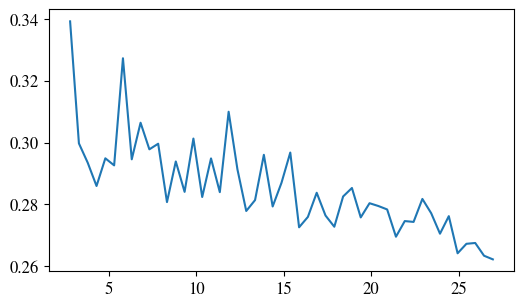

In [9]:
# Load arrays
agent_best_rewards_A2C = np.load('agent_best_rewards_A2C_S.npy')
#agent_best_rewards_A2C_pt2 = np.load('agent_best_rewards_A2C_CS.npy')
#agent_best_rewards_A2C_pt1 = np.load('agent_best_rewards_A2C_BS.npy')
#agent_best_rewards_A2C = np.concatenate([agent_best_rewards_A2C_pt1,agent_best_rewards_A2C_pt2, agent_best_rewards_A2C],axis=1)

agent_best_rewards_DQN = np.load('agent_best_rewards_DQN_S.npy')
agent_best_rewards_PPO = np.load('agent_best_rewards_PPO_S.npy')

max_flow_vals = np.load('max_flow_vals_S.npy')
optimal_obj_vals = np.load('optimal_obj_vals_S.npy')

max_flow_vals = max_flow_vals[0:1000]
optimal_obj_vals = np.mean(optimal_obj_vals[0:1000],axis=1)

#start_A2C = 10080000 
start = 2772000
end = 29988000
#end_A2C_pt1 = 5796000
end_A2C = 27216000
step = 252000*2

timesteps = np.array(list(range(start, end+1, step)))/1000000
timesteps_A2C = np.array(list(range(start, end_A2C+1, step)))/1000000
#timesteps_A2C_pt1 = np.array(list(range(start, end_A2C_pt1+1, step)))/1000000
#timesteps_A2C_pt2 = np.array(list(range(end_A2C_pt1, start_A2C+1, step)))/1000000
#timesteps_A2C = np.concatenate([timesteps_A2C_pt1,timesteps_A2C_pt2,timesteps_A2C])

relative_errors_A2C = np.mean(abs(agent_best_rewards_A2C-optimal_obj_vals[:,np.newaxis]) / (max_flow_vals[:,np.newaxis]-optimal_obj_vals[:,np.newaxis]),axis=0)
#relative_errors_A2C_pt1 = np.mean(abs(agent_best_rewards_A2C_pt1-optimal_obj_vals[:,np.newaxis]) / (max_flow_vals[:,np.newaxis]-optimal_obj_vals[:,np.newaxis]),axis=0)
relative_errors_DQN = np.mean(abs(agent_best_rewards_DQN-optimal_obj_vals[:,np.newaxis]) / (max_flow_vals[:,np.newaxis]-optimal_obj_vals[:,np.newaxis]),axis=0)
#relative_errors_PPO = np.mean(abs(agent_best_rewards_PPO-optimal_obj_vals[:,np.newaxis]) / (max_flow_vals[:,np.newaxis]-optimal_obj_vals[:,np.newaxis]),axis=0)

plt.figure(figsize=(6, 3.4))

plt.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

print(np.shape(timesteps_A2C))
plt.plot(timesteps_A2C, relative_errors_A2C, label='A2C')
#plt.plot(timesteps_A2C_pt1, relative_errors_A2C_pt1, label='A2C')
plt.plot(timesteps, relative_errors_DQN, label='DQN')
#plt.plot(timesteps, relative_errors_PPO, label='PPO')


#plt.title('Deterministic Network Interdiction Agent Training')
plt.xlabel('Training Step (Millions)')
plt.ylabel('Optimality Gap (%)')
plt.legend()

#Adjust viewing window
plt.xlim(0, 30)
plt.ylim(0, .9)

# Set x-axis ticks at each million5
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(5))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))  # If y is in 0-1 range

# Format x-axis tick labels with commas
def format_func(value, tick_number):
    return f"{value:,.0f}"

plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_func))

sns.despine()
plt.savefig('AgentTraining.png', dpi=300, bbox_inches='tight', format='png')

plt.show()

In [63]:
relative_errors_A2C

array([0.25437245, 0.26960661, 0.26156824, 0.24788244, 0.26651918,
       0.25971192, 0.26725856, 0.26069283, 0.26110686, 0.28797042,
       0.26519805, 0.25475376, 0.2773552 , 0.25296377, 0.27673046,
       0.26753153, 0.25208816, 0.24430547, 0.25536447, 0.25308075,
       0.27569955, 0.27369044, 0.27676815, 0.25657198, 0.26116222,
       0.25106348, 0.25753865, 0.24909953, 0.24776229, 0.24200764,
       0.2479674 , 0.25169198, 0.2323472 , 0.25763283, 0.23554153])

In [28]:
print(relative_errors)

[[0.45864026 0.02122565 0.00086621 ... 0.02483134 0.01595797 0.00883815]
 [0.50679941 0.28923328 0.1084918  ... 0.10150136 0.0816081  0.10937695]
 [0.36421066 0.09437766 0.3706729  ... 0.01992688 0.06516913 0.05408254]
 ...
 [0.08720859 0.08720859 0.08799803 ... 0.03436536 0.05760454 0.03569755]
 [0.21813254 0.1360881  0.1779482  ... 0.3835894  0.11119091 0.04822975]
 [0.31101368 0.30196952 0.16036177 ... 0.1047654  0.1047654  0.1047654 ]]


In [23]:
import collections
num_runs = 200

obs, _ = eval_env.reset(1)
action_list = []

budget = obs['budget'][0]

while budget >= 3:
    # Initialize a dictionary to accumulate sums for each key
    flow_sums = collections.defaultdict(float)

    # Run solve_max_flow 100 times and accumulate results
    for _ in range(num_runs):
        _, flow_vals = eval_env.solve_max_flow()
        for key, value in flow_vals.items():
            flow_sums[key] += value

    # Compute mean values for each key
    flow_means = {key: flow_sums[key] / num_runs for key in flow_sums}

    # Zero out values for keys not in interdictable_edges
    for key in flow_means:
        if key not in eval_env.interdictable_edges:
            flow_means[key] = 0.0

    # Find the key with the maximum mean value
    action_key = max(flow_means, key=flow_means.get)
    action = eval_env.interdictable_edges.index(action_key)

    obs, reward, done, _, _ = eval_env.step(action)
    budget = obs['budget'][0]
        

    action_list.append(action_key)
            
    if done:
        break
print(action_list)


[(10, 15), (13, 18), (17, 22)]


In [24]:
flow_means

{(1, 2): 0.0,
 (1, 3): 0.0,
 (1, 4): 0.0,
 (1, 5): 0.0,
 (1, 6): 0.0,
 (2, 7): 41.54,
 (3, 8): 22.55,
 (4, 9): 14.0,
 (5, 10): 11.67,
 (6, 11): 16.645,
 (7, 12): 41.54,
 (8, 13): 24.605,
 (9, 14): 11.765,
 (10, 15): 26.915,
 (11, 16): 1.58,
 (12, 17): 41.12,
 (13, 18): 25.9,
 (14, 19): 4.46,
 (15, 20): 12.355,
 (16, 21): 22.57,
 (17, 22): 43.32,
 (18, 23): 6.05,
 (19, 24): 32.855,
 (20, 25): 10.155,
 (21, 26): 14.025,
 (2, 3): 0.0,
 (3, 2): 0.0,
 (3, 4): 14.0,
 (4, 3): 0.0,
 (4, 5): 0.0,
 (5, 4): 0.0,
 (5, 6): 0.0,
 (6, 5): 0.0,
 (7, 8): 0.0,
 (8, 7): 0.0,
 (8, 9): 0.0,
 (9, 8): 2.055,
 (9, 10): 0.18,
 (10, 9): 0.0,
 (10, 11): 0.0,
 (11, 10): 15.065,
 (12, 13): 0.42,
 (13, 12): 0.0,
 (13, 14): 0.0,
 (14, 13): 0.875,
 (14, 15): 6.43,
 (15, 14): 0.0,
 (15, 16): 20.99,
 (16, 15): 0.0,
 (17, 18): 0.0,
 (18, 17): 2.2,
 (18, 19): 17.65,
 (19, 18): 0.0,
 (19, 20): 0.0,
 (20, 19): 10.745,
 (20, 21): 0.0,
 (21, 20): 8.545,
 (22, 23): 0.0,
 (23, 22): 0.0,
 (23, 24): 0.0,
 (24, 23): 0.0,
 (24, 25

In [14]:
eval_env.reset(1)
_, flow_vals = eval_env.solve_max_flow()

for key in flow_vals:
    if key not in eval_env.interdictable_edges:
        flow_vals[key] = 0.0
max_key = max(flow_vals, key=flow_vals.get)
action = eval_env.interdictable_edges.index(max_key)
print(action)

1


In [25]:
# Greedy Heuristic Trials - Deterministic

# Test Agent against a range of scenarios
num_of_scenarios = 10000

# Initialize arrays to store results
max_flow_vals =  np.zeros(num_of_scenarios)
optimal_obj_vals = np.zeros(num_of_scenarios)
agent_best_rewards = np.zeros((num_of_scenarios, len(agents)))

# Initialize a dictionary to keep track of actions
action_tally = [{i: 0 for i in eval_env.interdictable_edges} for _ in agents]


all_optimal_interdiction_edges = []
all_agent_actions =[]
agent_solution_times = np.zeros((num_of_scenarios, len(agents)))
optimal_solution_times=[]

for episode in tqdm(range(num_of_scenarios)):
    env.seed(seed=episode)
    obs = env.reset()
    eval_env.reset(seed=episode)
    #Determine Original Flow
    max_flow_vals[episode] = eval_env.reference_obj

    #Solve and Time Optimal Solution
    start_optimal_time = time.perf_counter()
    optimal_obj_val, optimal_interdiction_edges = eval_env.solve_optimal_interdiction()
#    optimal_obj_val, optimal_interdiction_edges = eval_env.solve_stochastic_max_flow2(n_scenarios = 1000)
    end_optimal_time = time.perf_counter()
    optimal_solution_times.append(end_optimal_time-start_optimal_time)

    #Save optimal solution value and interdiction set
    #print(optimal_obj_val)
    #print(optimal_interdiction_edges)
    optimal_obj_vals[episode] = optimal_obj_val
    all_optimal_interdiction_edges.append(frozenset(optimal_interdiction_edges))
    
    # Reset enviroments
    env.seed(seed=episode)
    obs = env.reset()
    eval_env.reset(seed=episode)
    action_list = []

    start_time = time.perf_counter()
    # Run agent with proper normalization
    budget = obs['budget'][0]
    while budget >=3:
        actions = obs['edge_capacity'][0]
        mask = obs['edge_interdicted'][0]
        masked_actions = [val if m != 1 else 0 for val, m in zip(actions, mask)]
        mask = obs['edge_costs'][0]
        masked_actions = np.where(mask > budget,0, masked_actions)
        action = np.argmax(masked_actions)
        obs, reward, done, _ = env.step([action])  # Use vectorized step API
        budget = obs['budget'][0]
        eval_env.step(action)
        # Tally actions using inner environment
        if action != env.get_attr("num_interdictable_edges")[0]:
            if action.item()<270:
                action_key = list(env.get_attr("interdictable_edges")[0])[action.item()]
                action_tally[a][action_key] += 1
                action_list.append(action_key)
            
        if done:
            break
    end_time = time.perf_counter()
    agent_solution_times[episode, a]=(end_time-start_time)
    all_agent_actions.append(frozenset(action_list))

        
    if env_deterministic ==True:
        # Get final objective value from inner environment
        objVal, _ = eval_env.solve_max_flow()
    else:
        interim_objective_value = []
        for i in range(200):
            objective_value, _ = eval_env.solve_max_flow()
            interim_objective_value.append(objective_value)
        objVal = np.mean(interim_objective_value)
        print(objVal)

    agent_best_rewards[episode, a] = objVal

#Print Results
print("Optimal Time to Solve (Mean): ",np.mean(optimal_solution_times))
print("")

for a, agent in enumerate(agents):
    # Calculate relative errors
    relative_errors = abs(agent_best_rewards[:,a]-optimal_obj_vals) / (max_flow_vals-optimal_obj_vals)
    # Create boolean mask using set operations
    condition_mask = np.array([
        agent_actions.issuperset(optimal_edges)
        for agent_actions, optimal_edges in zip(all_agent_actions, all_optimal_interdiction_edges)
    ])

    # Apply mask to zero out qualifying elements
    relative_errors[condition_mask] = 0
    
    # Calculate mean relative error
    mean_relative_error = np.nanmean(relative_errors)
    print(model_names[a], ": ", count_zeros(relative_errors))
    print("Mean Relative Error: ", mean_relative_error)
    print("RL Time to Solve (Mean): ", np.mean(agent_solution_times[:, a]))
    print("")

100%|██████████| 10000/10000 [02:27<00:00, 67.75it/s]

Optimal Time to Solve (Mean):  0.004214107366837561

G5x5_S_MaskablePPO_EX005A :  4171
Mean Relative Error:  0.41567700061070034
RL Time to Solve (Mean):  0.0

G5x5_S_MaskablePPO_EX005C :  196
Mean Relative Error:  0.710235602658624
RL Time to Solve (Mean):  0.005063241506367922



In [4]:
# Greedy Heuristic Trials - SNIP(IB)

# Test Agent against a range of scenarios
num_of_scenarios = 10000

# Initialize arrays to store results
max_flow_vals =  np.zeros(num_of_scenarios)
optimal_obj_vals = np.zeros((num_of_scenarios,30))
optimal_obj_vars = np.zeros(num_of_scenarios)
agent_best_rewards = np.zeros(num_of_scenarios)

# Initialize a dictionary to keep track of actions
action_tally = {i: 0 for i in eval_env.interdictable_edges}


all_optimal_interdiction_edges = {}
all_agent_actions ={}
agent_solution_times = np.zeros(num_of_scenarios)
optimal_solution_times=np.empty(num_of_scenarios)
optimal_count = 0

for episode in tqdm(range(num_of_scenarios)): #Outer Loop
    env.seed(seed=episode)
    obs = env.reset()
    eval_env.reset(seed=episode)
    #Determine Original Flow
    max_flow_vals[episode] = eval_env.reference_obj

    #Solve and Time Optimal Solution
    start_optimal_time = time.perf_counter()
    for i in range(30):
        optimal_obj_vals[episode,i], optimal_interdiction_edges = eval_env.solve_stochastic_max_flow(n_scenarios = 200, seed=i*episode)
    end_optimal_time = time.perf_counter()
    optimal_obj_vars[episode]= np.var(optimal_obj_vals[episode,:], ddof=1)
    optimal_solution_times[episode]=(end_optimal_time-start_optimal_time)

    all_optimal_interdiction_edges[episode]=(frozenset(optimal_interdiction_edges))
    
    # Reset enviroments
    env.seed(seed=episode)
    obs = env.reset()
    eval_env.reset(seed=episode)
    action_list = []

    start_time = time.perf_counter()
    # Run agent with proper normalization
    budget = obs['budget'][0]
    while budget >=3:
        actions = obs['edge_capacity'][0]*obs['edge_interdiction_probability'][0]/obs['edge_costs'][0]
        mask = obs['edge_interdicted'][0]
        masked_actions = [val if m != 1 else 0 for val, m in zip(actions, mask)]
        mask = obs['edge_costs'][0]
        masked_actions = np.where(mask > budget,0, masked_actions)
        action = np.argmax(masked_actions)
        obs, reward, done, _ = env.step([action])  # Use vectorized step API
        budget = obs['budget'][0]
        eval_env.step(action)
        # Tally actions using inner environment
        if action != env.get_attr("num_interdictable_edges")[0]:
            if action.item()<270:
                action_key = list(env.get_attr("interdictable_edges")[0])[action.item()]
                action_tally[action_key] += 1
                action_list.append(action_key)
            
        if done:
            break
    end_time = time.perf_counter()
    agent_solution_times[episode]=(end_time-start_time)
    all_agent_actions[episode] = (frozenset(action_list))

    interim_objective_value = np.empty(1000)
    for i in range(1000):
        interim_objective_value[i], _ = eval_env.solve_max_flow()
    agent_best_rewards[episode] = np.mean(interim_objective_value)
    t_stat, p_val = ttest_ind(optimal_obj_vals[episode,:], interim_objective_value, equal_var=False)

    if p_val>=0.05:
        optimal_count+=1       
   

#Print Results
print("Optimal Time to Solve (Mean): ",np.mean(optimal_solution_times))
print("")

relative_errors = abs(agent_best_rewards-np.mean(optimal_obj_vals, axis=1)) / (max_flow_vals-np.mean(optimal_obj_vals, axis=1))
# Create boolean mask using set operations
#condition_mask = np.array([
#    agent_actions.issuperset(optimal_edges)
#    for agent_actions, optimal_edges in zip(all_agent_actions, all_optimal_interdiction_edges)
#])

# Apply mask to zero out qualifying elements
#relative_errors[condition_mask] = 0
    
# Calculate mean relative error
mean_relative_error = np.nanmean(relative_errors)
print("Heuristic: ", optimal_count/num_of_scenarios)
print("Mean Relative Error: ", mean_relative_error)
print("RL Time to Solve (Mean): ", np.mean(agent_solution_times))
print("")

/state/partition1/llgrid/pkg/anaconda/python-ML-2025a/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
  0%|          | 3/10000 [00:54<50:04:47, 18.03s/it]

KeyboardInterrupt



In [19]:
#Parallelized SNIP(IB) and Heuristic - add save for results, test with GPU core, then adapt for SNIP(IM)

# Worker function for parallel execution
def run_episode(episode):
    obs, _ = eval_env.reset(seed=episode)
    
    # Episode processing (same as original loop body)
    max_flow_val = eval_env.reference_obj
    
    # Optimal solution calculation
    start_optimal_time = time.perf_counter()
    optimal_obj_vals_ep = np.zeros(30)
    for i in range(30):
        optimal_obj_vals_ep[i], optimal_interdiction_edges = eval_env.solve_stochastic_max_flow(n_scenarios=200, seed=i*episode)

    end_optimal_time = time.perf_counter()
    optimal_obj_var = np.var(optimal_obj_vals_ep, ddof=1)
    optimal_solution_time = end_optimal_time - start_optimal_time
    
    # Greedy Heuristic (Eliminate Greatest Expected Capacity per Unit of Cost)
    action_list = []
    start_time = time.perf_counter()
    budget = obs['budget'][0]
    
    while budget >= 3:
        actions = obs['edge_capacity'] /obs['edge_costs'] * obs['edge_interdiction_probability'][0]
        mask = obs['edge_interdicted']
        masked_actions = [val if m != 1 else 0 for val, m in zip(actions, mask)]
        mask = obs['edge_interdiction_probability']
        masked_actions = [val if m != 0 else 0 for val, m in zip(masked_actions, mask)]
        mask = obs['edge_costs']
        masked_actions = [val if m <= budget else 0 for val, m in zip(masked_actions, mask)] #np.where(mask_costs > budget, 0, masked_actions)
        action = np.argmax(masked_actions)
        #print(action)
        #eval_env.render()
        obs, reward, done, _, _ = eval_env.step(action)
        budget = obs['budget'][0]
        
        if action != env.get_attr("num_interdictable_edges")[0] and action.item() < 270:
            action_key = list(env.get_attr("interdictable_edges")[0])[action.item()]
            action_list.append(action_key)
            
        if done:
            break
    
    end_time = time.perf_counter()
    agent_solution_time = end_time - start_time
    
    # Evaluation
    interim_objective_value = np.empty(1000)
    for i in range(1000):
        interim_objective_value[i], _ = eval_env.solve_max_flow()
    agent_best_reward = np.mean(interim_objective_value)
    #print(optimal_obj_vals_ep)
    #print(interim_objective_value)

    # Add in worker function:
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", 
            message="Precision loss occurred in moment calculation", 
            category=RuntimeWarning
        )
    t_stat, p_val = ttest_ind(optimal_obj_vals_ep, interim_objective_value, equal_var=False)
    
    return {
        'episode': episode,
        'max_flow_val': max_flow_val,
        'optimal_obj_vals': optimal_obj_vals_ep,
        'optimal_obj_var': optimal_obj_var,
        'optimal_solution_time': optimal_solution_time,
        'optimal_edges': frozenset(optimal_interdiction_edges),
        'agent_solution_time': agent_solution_time,
        'agent_actions': frozenset(action_list),
        'agent_best_reward': agent_best_reward,
        'p_val': p_val,
        'actions_taken': action_list
    }

# Main parallel execution
if __name__ == '__main__':
    num_of_scenarios = 10000
    num_workers = multiprocessing.cpu_count()
    
    # Initialize results containers
    max_flow_vals = np.zeros(num_of_scenarios)
    optimal_obj_vals = np.zeros((num_of_scenarios, 30))
    optimal_obj_vars = np.zeros(num_of_scenarios)
    agent_best_rewards = np.zeros(num_of_scenarios)
    agent_solution_times = np.zeros(num_of_scenarios)
    optimal_solution_times = np.zeros(num_of_scenarios)
    all_optimal_edges = {}
    all_agent_actions = {}
 #   action_tally = {i: 0 for i in eval_env.interdictable_edges}
    action_tally = {i: 0 for i in eval_env.interdictable_edges}

    optimal_count = 0

    with ProcessPoolExecutor(max_workers=num_workers) as executor:
        futures = [executor.submit(run_episode, ep) 
                  for ep in range(num_of_scenarios)]
        
        for future in tqdm(futures, total=num_of_scenarios, desc="Processing episodes"):
            result = future.result()
            ep = result['episode']
            
            # Store results
            max_flow_vals[ep] = result['max_flow_val']
            optimal_obj_vals[ep] = result['optimal_obj_vals']
            optimal_obj_vars[ep] = result['optimal_obj_var']
            optimal_solution_times[ep] = result['optimal_solution_time']
            all_optimal_edges[ep] = result['optimal_edges']
            agent_solution_times[ep] = result['agent_solution_time']
            all_agent_actions[ep] = result['agent_actions']
            agent_best_rewards[ep] = result['agent_best_reward']
            
            # Update action tally
            for action in result['actions_taken']:
                action_tally[action] += 1
            
            if result['p_val'] >= 0.05:
                optimal_count += 1

    # Post-processing and output (same as original)
    relative_errors = abs(agent_best_rewards - np.mean(optimal_obj_vals, axis=1)) / (max_flow_vals - np.mean(optimal_obj_vals, axis=1))
    mean_relative_error = np.nanmean(relative_errors)
    
    print("Optimal Time to Solve (Mean):", np.mean(optimal_solution_times))
    print("\nHeuristic:", optimal_count/num_of_scenarios)
    print("Mean Relative Error:", mean_relative_error)
    print("RL Time to Solve (Mean):", np.mean(agent_solution_times))

    # Save arrays as .npy files
    np.save('max_flow_vals_S.npy', max_flow_vals)
    np.save('optimal_obj_vals_S.npy', optimal_obj_vals)
    np.save('optimal_obj_vars_S.npy', optimal_obj_vars)
    np.save('agent_best_rewards_S.npy', agent_best_rewards)

    # Save frozenset list as .pkl file
    with open('all_optimal_interdiction_edges_S.pkl', 'wb') as f:
        pickle.dump(all_optimal_edges, f)
    with open('all_agent_actions_S.pkl', 'wb') as f:
        pickle.dump(all_agent_actions, f)

/state/partition1/llgrid/pkg/anaconda/python-ML-2025a/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/state/partition1/llgrid/pkg/anaconda/python-ML-2025a/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/state/partition1/llgrid/pkg/anaconda/python-ML-2025a/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds

Optimal Time to Solve (Mean): 23.00913415364921

Heuristic: 0.0
Mean Relative Error: 0.6305117975907133
RL Time to Solve (Mean): 0.04821459511294961


In [22]:
agent_best_rewards

array([ 96.   , 113.   ,  83.194, 123.   , 119.   ,  83.   ,  95.   ,
       124.   ,  89.24 ,  63.   ])

In [ ]:
#Parallelized SNIP(IM) and Heuristic - add save for results, test with
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
import multiprocessing

# Worker function for parallel execution
def run_episode(episode):
    # Recreate environments from config (thread-safe)
    env.seed(seed=episode)
    obs = env.reset()
    eval_env.reset(seed=episode)
    
    # Episode processing (same as original loop body)
    max_flow_val = eval_env.reference_obj
    
    # Optimal solution calculation
    start_optimal_time = time.perf_counter()
    optimal_obj_vals_ep = np.zeros(30)
    for i in range(30):
        optimal_obj_vals_ep[i], optimal_interdiction_edges = eval_env.solve_stochastic_max_flow(n_scenarios=200)
    end_optimal_time = time.perf_counter()
    optimal_obj_var = np.var(optimal_obj_vals_ep, ddof=1)
    optimal_solution_time = end_optimal_time - start_optimal_time
    
    # Agent simulation
    env.seed(seed=episode)
    obs = env.reset()
    eval_env.reset(seed=episode)
    action_list = []
    start_time = time.perf_counter()
    budget = obs['budget'][0]
    
    while budget >= 3:
        actions = obs['edge_capacity'][0] * obs['edge_interdiction_probability'][0]
        mask = obs['edge_interdicted'][0]
        masked_actions = [val if m != 1 else 0 for val, m in zip(actions, mask)]
        mask_costs = obs['edge_costs'][0]
        masked_actions = np.where(mask_costs > budget, 0, masked_actions)
        action = np.argmax(masked_actions)
        obs, reward, done, _ = env.step([action])
        budget = obs['budget'][0]
        eval_env.step(action)
        
        if action != env.get_attr("num_interdictable_edges")[0] and action.item() < 270:
            action_key = list(env.get_attr("interdictable_edges")[0])[action.item()]
            action_list.append(action_key)
            
        if done:
            break
    
    end_time = time.perf_counter()
    agent_solution_time = end_time - start_time
    
    # Evaluation
    interim_objective_value = np.empty(1000)
    for i in range(1000):
        interim_objective_value[i], _ = eval_env.solve_max_flow()
    agent_best_reward = np.mean(interim_objective_value)
    
    t_stat, p_val = ttest_ind(optimal_obj_vals_ep, interim_objective_value, equal_var=False)
    
    return {
        'episode': episode,
        'max_flow_val': max_flow_val,
        'optimal_obj_vals': optimal_obj_vals_ep,
        'optimal_obj_var': optimal_obj_var,
        'optimal_solution_time': optimal_solution_time,
        'optimal_edges': frozenset(optimal_interdiction_edges),
        'agent_solution_time': agent_solution_time,
        'agent_actions': frozenset(action_list),
        'agent_best_reward': agent_best_reward,
        'p_val': p_val,
        'actions_taken': action_list
    }

# Main parallel execution
if __name__ == '__main__':
    num_of_scenarios = 10000
    num_workers = multiprocessing.cpu_count()
    
    # Initialize results containers
    max_flow_vals = np.zeros(num_of_scenarios)
    optimal_obj_vals = np.zeros((num_of_scenarios, 30))
    optimal_obj_vars = np.zeros(num_of_scenarios)
    agent_best_rewards = np.zeros(num_of_scenarios)
    agent_solution_times = np.zeros(num_of_scenarios)
    optimal_solution_times = np.zeros(num_of_scenarios)
    all_optimal_edges = {}
    all_agent_actions = {}
    action_tally = {i: 0 for i in eval_env.interdictable_edges}
    optimal_count = 0

    with ProcessPoolExecutor(max_workers=num_workers) as executor:
        futures = [executor.submit(run_episode, ep) 
                  for ep in range(num_of_scenarios)]
        
        for future in tqdm(futures, total=num_of_scenarios, desc="Processing episodes"):
            result = future.result()
            ep = result['episode']
            
            # Store results
            max_flow_vals[ep] = result['max_flow_val']
            optimal_obj_vals[ep] = result['optimal_obj_vals']
            optimal_obj_vars[ep] = result['optimal_obj_var']
            optimal_solution_times[ep] = result['optimal_solution_time']
            all_optimal_edges[ep] = result['optimal_edges']
            agent_solution_times[ep] = result['agent_solution_time']
            all_agent_actions[ep] = result['agent_actions']
            agent_best_rewards[ep] = result['agent_best_reward']
            
            # Update action tally
            for action in result['actions_taken']:
                action_tally[action] += 1
            
            if result['p_val'] >= 0.05:
                optimal_count += 1

    # Post-processing and output (same as original)
    relative_errors = abs(agent_best_rewards - np.mean(optimal_obj_vals, axis=1)) / (max_flow_vals - np.mean(optimal_obj_vals, axis=1))
    mean_relative_error = np.nanmean(relative_errors)
    
    print("Optimal Time to Solve (Mean):", np.mean(optimal_solution_times))
    print("\nHeuristic:", optimal_count/num_of_scenarios)
    print("Mean Relative Error:", mean_relative_error)
    print("RL Time to Solve (Mean):", np.mean(agent_solution_times))

In [69]:
eval_env.reset(seed=1)
#print(eval_env.solve_optimal_interdiction())
#eval_env.interdictable_edges
eval_env.step(14)
eval_env.step(15)
eval_env.step(17)
eval_env.step(18)
list_vals = np.empty(10000)
for t in range(10000):
    list_vals[t], flow = eval_env.solve_max_flow()

In [70]:
np.var(list_vals, ddof=1)

1117.111110111011

In [89]:
stoc_res = np.empty(30)
for i in range(30):
    eval_env.reset(seed=1)
    stoc_res[i], _ = eval_env.solve_stochastic_max_flow(n_scenarios=200)
np.var(stoc_res, ddof=1)

3.8032047126436925

In [90]:
stoc_res

array([56.17 , 54.84 , 54.485, 57.455, 54.54 , 51.585, 54.095, 54.29 ,
       57.385, 55.665, 56.285, 57.35 , 59.78 , 58.83 , 57.535, 59.195,
       57.03 , 53.225, 56.375, 56.845, 56.49 , 57.945, 55.94 , 57.19 ,
       52.045, 56.605, 54.52 , 57.075, 54.45 , 55.15 ])

In [12]:

#Test Performance over a range of budgets
num_of_scenarios = 1000


mean_relative_error_list = []#np.zeros((num_of_scenarios, len(agents)))
budget_list = []


for i in  range(3,26): #[5,15,30]:#
    env_initial_budget = i
    print("Budget: ", i)
    budget_list.append(i)    

    env = ce.CustomEnv(nodes, edges, deterministic_agent=env_deterministic,
                   fixed_costs= env_fixed_costs,
                   curriculum_training=env_curriculum_training,
                   initial_budget=env_initial_budget)

    eval_env = ce.CustomEnv(nodes, edges, deterministic_agent=env_deterministic,
                   fixed_costs= env_fixed_costs,
                   curriculum_training=env_curriculum_training,
                   initial_budget=env_initial_budget)


    env = DummyVecEnv([lambda: env])

    # 2. Load normalization statistics and wrap environment
#    env = VecNormalize.load(f"{models_dir}/{model_names[0]}/{model_names[0]}_vecnormalize_{model_timesteps[0]}_steps.pkl", env)
#
    # 3. Set evaluation mode
#    env.training = False
#    env.norm_reward = False

    # Modified Trial for VecNormalized

    # Test Agent against a range of scenarios

    # Initialize arrays to store results
    max_flow_vals =  np.zeros(num_of_scenarios)
    optimal_obj_vals = np.zeros(num_of_scenarios)
    agent_best_rewards = np.zeros((num_of_scenarios, len(agents)))

    # Initialize a dictionary to keep track of actions
    action_tally = [{i: 0 for i in eval_env.interdictable_edges} for _ in agents]

    all_optimal_interdiction_edges = []
    agent_solution_times = np.zeros((num_of_scenarios, len(agents)))
    optimal_solution_times=[]

    for episode in tqdm(range(num_of_scenarios)):
        env.seed(seed=episode)
        obs = env.reset()
        eval_env.reset(seed=episode)
        #Determine Original Flow
        max_flow_vals[episode] = eval_env.reference_obj

        #Solve and Time Optimal Solution
        start_optimal_time = time.perf_counter()
        optimal_obj_val, optimal_interdiction_edges = eval_env.solve_optimal_interdiction()
        end_optimal_time = time.perf_counter()
        optimal_solution_times.append(end_optimal_time-start_optimal_time)

        #Save optimal solution value and interdiction set
        optimal_obj_vals[episode] = optimal_obj_val
        all_optimal_interdiction_edges.append(frozenset(optimal_interdiction_edges))
    
        for a, agent in enumerate(agents):
            # Reset enviroments
            env.seed(seed=episode)
            obs = env.reset()
            eval_env.reset(seed=episode)

            start_time = time.perf_counter()
            # Run agent with proper normalization
            for _ in range(31):
                # Get action mask through vectorized environment method
                #action_masks = env.env_method("action_masks")[0]
                action, _ = agent.predict(obs, deterministic=True)
                # Use wrapper's step method
                obs, reward, done, _ = env.step([action])  # Use vectorized step API
                eval_env.step(action)
                # Tally actions using inner environment
               # if action != env.get_attr("num_interdictable_edges")[0]:
               #     action_key = list(env.get_attr("interdictable_edges")[0])[action.item()]
               #     action_tally[a][action_key] += 1
            
                if done:
                    break
            end_time = time.perf_counter()
            agent_solution_times[episode, a]=(end_time-start_time)

            if env_deterministic ==True:
                # Get final objective value from inner environment
                objVal, _ = eval_env.solve_max_flow()
            else:
                interim_objective_value = []
                for i in range(50):
                    objective_value, _ = eval_env.solve_max_flow()
                    interim_objective_value.append(objective_value)
                objVal = np.mean(interim_objective_value)
    
            agent_best_rewards[episode, a] = objVal

    #Print Results
    print("Optimal Time to Solve (Mean): ",np.mean(optimal_solution_times))
    print("")

    for a, agent in enumerate(agents):
        # Calculate relative errors
        relative_errors = (agent_best_rewards[:,a]-optimal_obj_vals) / (max_flow_vals-optimal_obj_vals)
        # Calculate mean relative error
        mean_relative_error = np.nanmean(relative_errors)
        print(model_names[a], ": ", count_zeros(relative_errors))
        print("Mean Relative Error: ", mean_relative_error)
        print("RL Time to Solve (Mean): ", np.mean(agent_solution_times[:, a]))
        print("")
    mean_relative_error_list.append(mean_relative_error)#[i-3,a] = mean_relative_error

Budget:  3


  0%|          | 4/1000 [00:28<1:58:17,  7.13s/it]


KeyboardInterrupt: 

In [3]:
import numpy as np
import time
from multiprocessing import Pool, cpu_count
from tqdm import tqdm

# Assumed imports for your environment and agents
# import ce
# from stable_baselines3.common.vec_env import DummyVecEnv

# Define your helper functions if needed, e.g., count_zeros
def count_zeros(arr):
    return np.sum(np.isnan(arr) | (arr == 0))

# Placeholders for your objects and parameters (replace with your actual objects)


num_of_scenarios = 1000

def run_budget_scenario(env_initial_budget):
    print(f"Processing budget: {env_initial_budget}")
    # Set up environments for this budget
    env = ce.CustomEnv(nodes, edges, deterministic_agent=env_deterministic,
                       fixed_costs=env_fixed_costs,
                       curriculum_training=env_curriculum_training,
                       initial_budget=env_initial_budget)

    eval_env = ce.CustomEnv(nodes, edges, deterministic_agent=env_deterministic,
                            fixed_costs=env_fixed_costs,
                            curriculum_training=env_curriculum_training,
                            initial_budget=env_initial_budget)

    env = DummyVecEnv([lambda: env])

    max_flow_vals = np.zeros(num_of_scenarios)
    optimal_obj_vals = np.zeros(num_of_scenarios)
    agent_best_rewards = np.zeros((num_of_scenarios, len(agents)))
    action_tally = [{i: 0 for i in eval_env.interdictable_edges} for _ in agents]
    all_optimal_interdiction_edges = []
    agent_solution_times = np.zeros((num_of_scenarios, len(agents)))
    optimal_solution_times = []

    for episode in range(num_of_scenarios):
        env.seed(seed=episode)
        obs = env.reset()
        eval_env.reset(seed=episode)
        # Determine Original Flow
        max_flow_vals[episode] = eval_env.reference_obj

        # Solve and Time Optimal Solution
        start_optimal_time = time.perf_counter()
        optimal_obj_val, optimal_interdiction_edges = eval_env.solve_optimal_interdiction()
        end_optimal_time = time.perf_counter()
        optimal_solution_times.append(end_optimal_time - start_optimal_time)

        # Save optimal solution value and interdiction set
        optimal_obj_vals[episode] = optimal_obj_val
        all_optimal_interdiction_edges.append(frozenset(optimal_interdiction_edges))

        for a, agent in enumerate(agents):
            # Reset environments
            env.seed(seed=episode)
            obs = env.reset()
            eval_env.reset(seed=episode)

            start_time = time.perf_counter()
            # Run agent with proper normalization
            for _ in range(31):
                action, _ = agent.predict(obs, deterministic=True)
                obs, reward, done, _ = env.step([action])  # Use vectorized step API
                eval_env.step(action)
                # Tally actions using inner environment (optional)
                # if action != env.get_attr("num_interdictable_edges")[0]:
                #     action_key = list(env.get_attr("interdictable_edges")[0])[action.item()]
                #     action_tally[a][action_key] += 1
                if done:
                    break
            end_time = time.perf_counter()
            agent_solution_times[episode, a] = (end_time - start_time)

            if env_deterministic:
                # Get final objective value from inner environment
                objVal, _ = eval_env.solve_max_flow()
            else:
                interim_objective_value = []
                for _ in range(50):
                    objective_value, _ = eval_env.solve_max_flow()
                    interim_objective_value.append(objective_value)
                objVal = np.mean(interim_objective_value)

            agent_best_rewards[episode, a] = objVal

    # Calculate mean relative errors for each agent
    mean_relative_errors = []
    for a, agent in enumerate(agents):
        relative_errors = (agent_best_rewards[:, a] - optimal_obj_vals) / (max_flow_vals - optimal_obj_vals)
        mean_relative_error = np.nanmean(relative_errors)
        mean_relative_errors.append(mean_relative_error)

    # Optionally, print results for this budget
    print("Optimal Time to Solve (Mean): ", np.mean(optimal_solution_times))
    for a, agent in enumerate(agents):
        relative_errors = (agent_best_rewards[:, a] - optimal_obj_vals) / (max_flow_vals - optimal_obj_vals)
        mean_relative_error = mean_relative_errors[a]
        print(model_names[a], ": ", count_zeros(relative_errors))
        print("Mean Relative Error: ", mean_relative_error)
        print("RL Time to Solve (Mean): ", np.mean(agent_solution_times[:, a]))
        print("")

    return (env_initial_budget, mean_relative_errors)

if __name__ == "__main__":
    budgets = list(range(3, 26))
    results = []
    with Pool(cpu_count()) as pool:
        for res in tqdm(pool.imap_unordered(run_budget_scenario, budgets), total=len(budgets)):
            results.append(res)
    # Aggregate results
    budget_list, mean_relative_error_list = zip(*results)
    # If you want to print or save the results:
    print("Budgets:", budget_list)
    print("Mean Relative Errors:", mean_relative_error_list)

Processing budget: 3

  0%|          | 0/23 [00:00<?, ?it/s]

Processing budget: 5Processing budget: 8Processing budget: 6Processing budget: 10Processing budget: 4Processing budget: 15Processing budget: 17Processing budget: 7Processing budget: 16Processing budget: 9Processing budget: 12Processing budget: 11Processing budget: 14
Processing budget: 20
Processing budget: 13


Processing budget: 23Processing budget: 22

Processing budget: 25Processing budget: 18Processing budget: 21
Processing budget: 19


Processing budget: 24













Process ForkPoolWorker-108:2<?, ?it/s]
Process ForkPoolWorker-104:
Process ForkPoolWorker-76:
Process ForkPoolWorker-24:
Process ForkPoolWorker-114:
Process ForkPoolWorker-51:
Process ForkPoolWorker-46:
Process ForkPoolWorker-105:
Process ForkPoolWorker-101:
Process ForkPoolWorker-99:
Process ForkPoolWorker-118:
Process ForkPoolWorker-113:
Process ForkPoolWorker-116:
Process ForkPoolWorker-89:
Process ForkPoolWorker-66:
Process ForkPoolWorker-100:
Process ForkPoolWorker-112:
Process ForkPoolWorker-115:
Process ForkPoolWorker-74:
Process ForkPoolWorker-107:
Process ForkPoolWorker-98:
Process ForkPoolWorker-96:
Process ForkPoolWorker-106:
Process ForkPoolWorker-103:
Process ForkPoolWorker-75:
Process ForkPoolWorker-80:
Process ForkPoolWorker-110:
Process ForkPoolWorker-81:
Process ForkPoolWorker-26:
Process ForkPoolWorker-92:
Process ForkPoolWorker-87:
Process ForkPoolWorker-86:
Process ForkPoolWorker-111:
Process ForkPoolWorker-72:
Process ForkPoolWorker-84:
Process ForkPoolWorker-67:
P

KeyboardInterrupt: 

In [ ]:
import numpy as np
import time
from tqdm import tqdm
from multiprocessing import Pool

# --- User-defined functions/classes assumed available:
# - ce.CustomEnv
# - agents: a list of pre-initialized agent objects
# - model_names: list of agent model names
# - count_zeros: function to count zeros in an array
# - create_agent: function to create agent instances (if needed)
# - nodes, edges, env_fixed_costs, env_curriculum_training, env_deterministic

num_of_scenarios = 100
mean_relative_error_list = []
budget_list = []

def run_episode(args):
    episode, env_params, agent_params, env_deterministic, model_names = args

    # Recreate environments
    env = ce.CustomEnv(**env_params)
    eval_env = ce.CustomEnv(**env_params)
    env = DummyVecEnv([lambda: env])

    # Recreate agents
    #agents = []
    #for agent_param in agent_params:
    #    agent = agent_param['agent_class'](**agent_param['init_args'])
    #    agents.append(agent)

    # Set seeds
    env.seed(seed=episode)
    obs = env.reset()
    eval_env.reset(seed=episode)

    max_flow_val = eval_env.reference_obj

    # Solve and time optimal solution
    start_optimal_time = time.perf_counter()
    optimal_obj_val, optimal_interdiction_edges = eval_env.solve_optimal_interdiction()
    end_optimal_time = time.perf_counter()
    optimal_solution_time = end_optimal_time - start_optimal_time

    all_optimal_interdiction_edges = frozenset(optimal_interdiction_edges)
    agent_best_rewards = np.zeros(len(agents))
    agent_solution_times = np.zeros(len(agents))

    for a, agent in enumerate(agents):
        env.seed(seed=episode)
        obs = env.reset()
        eval_env.reset(seed=episode)

        start_time = time.perf_counter()
        for _ in range(31):
            action, _ = agent.predict(obs, deterministic=True)
            obs, reward, done, _ = env.step([action])
            eval_env.step(action)
            if done:
                break
        end_time = time.perf_counter()
        agent_solution_times[a] = end_time - start_time

        if env_deterministic:
            objVal, _ = eval_env.solve_max_flow()
        else:
            interim_objective_value = []
            for _ in range(50):
                objective_value, _ = eval_env.solve_max_flow()
                interim_objective_value.append(objective_value)
            objVal = np.mean(interim_objective_value)
        agent_best_rewards[a] = objVal

    return (
        max_flow_val,
        optimal_obj_val,
        optimal_solution_time,
        agent_best_rewards,
        agent_solution_times,
        all_optimal_interdiction_edges
    )

for i in range(3, 4):
    env_initial_budget = i
    print("Budget: ", i)
    budget_list.append(i)

    env_params = {
        'nodes': nodes,
        'edges': edges,
        'deterministic_agent': env_deterministic,
        'fixed_costs': env_fixed_costs,
        'curriculum_training': env_curriculum_training,
        'initial_budget': env_initial_budget
    }

    # Prepare agent parameters for recreation in subprocesses
    agent_params = []
  #  for agent in agents:
  #     agent_params.append({
  #          'agent_class': agent.__class__,
  #          'init_args': agent.get_init_args()  # You must implement this method to return the agent's constructor args
  #      })

    episode_args = [
        (ep, env_params, agent_params, env_deterministic, model_names)
        for ep in range(num_of_scenarios)
    ]

    max_flow_vals = np.zeros(num_of_scenarios)
    optimal_obj_vals = np.zeros(num_of_scenarios)
    agent_best_rewards = np.zeros((num_of_scenarios, len(agents)))
    agent_solution_times = np.zeros((num_of_scenarios, len(agents)))
    optimal_solution_times = []

    with Pool() as pool:
        results = list(tqdm(pool.imap_unordered(run_episode, episode_args), total=num_of_scenarios))

    for idx, result in enumerate(results):
        max_flow_vals[idx] = result[0]
        optimal_obj_vals[idx] = result[1]
        optimal_solution_times.append(result[2])
        agent_best_rewards[idx, :] = result[3]
        agent_solution_times[idx, :] = result[4]
        # result[5] is the optimal interdiction edges, store if needed

    print("Optimal Time to Solve (Mean): ", np.mean(optimal_solution_times))
    print("")

    for a, agent in enumerate(agents):
        relative_errors = (agent_best_rewards[:, a] - optimal_obj_vals) / (max_flow_vals - optimal_obj_vals)
        mean_relative_error = np.nanmean(relative_errors)
        print(model_names[a], ": ", count_zeros(relative_errors))
        print("Mean Relative Error: ", mean_relative_error)
        print("RL Time to Solve (Mean): ", np.mean(agent_solution_times[:, a]))
        print("")
    mean_relative_error_list.append(mean_relative_error)

Budget:  3


  4%|▍         | 4/100 [00:15<03:59,  2.49s/it]

In [4]:
for i in range(3, 4):
    print(i)

3


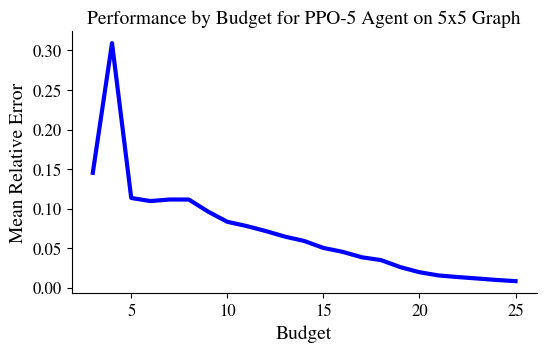

In [9]:
plt.figure(figsize=(6, 3.4))

plt.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'



plt.plot(budget_list, mean_relative_error_list, color='blue', linewidth=3)
plt.xlabel('Budget')
plt.ylabel('Mean Relative Error')
plt.title('Performance by Budget for PPO-5 Agent on 5x5 Graph')
sns.despine()
#plt.grid(True)
plt.show()